In [1]:
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
import time
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter


from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [2]:
gbin1 = np.load('/home/jua/corsika/run/energy_var/npz/square/bin/gamma_energy_bin1_all.npz')
pbin1 = np.load('/home/jua/corsika/run/energy_var/npz/square/bin/proton_energy_bin1_all.npz')

gbin2 = np.load('/home/jua/corsika/run/energy_var/npz/square/bin/gamma_energy_bin2_all.npz')
pbin2 = np.load('/home/jua/corsika/run/energy_var/npz/square/bin/proton_energy_bin2_all.npz')

gbin3 = np.load('/home/jua/corsika/run/energy_var/npz/square/bin/gamma_energy_bin3_all.npz')
pbin3 = np.load('/home/jua/corsika/run/energy_var/npz/square/bin/proton_energy_bin3_all.npz')

gbin4 = np.load('/home/jua/corsika/run/energy_var/npz/square/bin/gamma_energy_bin4_all.npz')
pbin4 = np.load('/home/jua/corsika/run/energy_var/npz/square/bin/proton_energy_bin4_all.npz')

gbin5 = np.load('/home/jua/corsika/run/energy_var/npz/square/bin/gamma_energy_bin5_all.npz')
pbin5 = np.load('/home/jua/corsika/run/energy_var/npz/square/bin/proton_energy_bin5_all.npz')

gbin6 = np.load('/home/jua/corsika/run/energy_var/npz/square/bin/gamma_energy_bin6_all.npz')
pbin6 = np.load('/home/jua/corsika/run/energy_var/npz/square/bin/proton_energy_bin6_all.npz')

gbin7 = np.load('/home/jua/corsika/run/energy_var/npz/square/bin/gamma_energy_bin7_all.npz')
pbin7 = np.load('/home/jua/corsika/run/energy_var/npz/square/bin/proton_energy_bin7_all.npz')

gbin8 = np.load('/home/jua/corsika/run/energy_var/npz/square/bin/gamma_energy_bin8_all.npz')
pbin8 = np.load('/home/jua/corsika/run/energy_var/npz/square/bin/proton_energy_bin8_all.npz')

gbin9 = np.load('/home/jua/corsika/run/energy_var/npz/square/bin/gamma_energy_bin9_all.npz')
pbin9 = np.load('/home/jua/corsika/run/energy_var/npz/square/bin/proton_energy_bin9_all.npz')

In [3]:
Ebins = 1
gim = gbin1['image'][:]
pim = pbin1['image'][:]
gim_label = torch.zeros([len(gim)])
pim_label = torch.ones([len(pim)]) 
classes = {0:'gamma',1:'proton'}

In [4]:
images = np.vstack((gim,pim))
labels = np.hstack((gim_label, pim_label))

In [5]:
images = torch.tensor(images).float()
labels = torch.tensor(labels).float()

In [6]:
sets = [(images[i],labels[i])for i in range(len(labels))]
shuffle(sets)

In [7]:
train_sets = sets[:int(len(sets)*0.5)]
valid_sets = sets[int(len(sets)*0.5):int(len(sets)*0.75)]
test_sets = sets[int(len(sets)*0.75):]

In [8]:
batchsize = 4
trainloader = torch.utils.data.DataLoader(train_sets, batch_size=batchsize, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(valid_sets, batch_size=batchsize, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_sets, batch_size=batchsize, shuffle=True, num_workers=2)

In [9]:
print('# of gamma images : {}, # of proton images : {}'.format(len(gim),len(pim)))
print('# of Train : {}, # of valid : {}, # of Test : {}'.format(len(train_sets),len(valid_sets),len(test_sets)))

# of gamma images : 59, # of proton images : 11
# of Train : 35, # of valid : 17, # of Test : 18


In [10]:
dataloader = {'train':trainloader, 'valid':validloader,'test':testloader}
datasize = {'train': len(train_sets),'valid':len(valid_sets), 'test':len(test_sets)}

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.layer1 =  nn.Sequential(
            nn.Conv2d(4,64,3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            nn.Conv2d(64,128,3, padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            nn.Conv2d(128,256,3, padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            nn.Conv2d(256,512,3, padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool2d(output_size=(7, 7))
            )
        self.layer2 = nn.Sequential(
            nn.Linear(in_features=512*7*7, out_features=128, bias=True),
            #nn.Linear(in_features=256, out_features=128, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=128, out_features=128, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=128, out_features=1, bias=True)
        )
        
    def forward(self, x):
        x = self.layer1(x)
        #x = x.mean(dim=(2,3))
        x = x.view(-1,512*7*7)
        x = self.layer2(x)
        return x


In [12]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        # print('Reset parameters of Linear')
        m.reset_parameters()

def freeze_conv(m):
    if isinstance(m, nn.Conv2d):
        # print('Freeze parameters of Conv2d')
        m.weight.requires_grad = False
        if m.bias is not None:
            m.bias.requires_grad = False

In [13]:
net = Net()

if Ebins > 3:
    net.load_state_dict(torch.load("model/best_B1_1.pth"))  
    net.apply(weight_init)
    net.apply(freeze_conv)

device=torch.device('cuda')
net.to(device)
net.eval()

Net(
  (layer1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True

In [14]:
learning_rate = 0.001
criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.Adam(net.parameters(), lr=learning_rate)
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
#exp_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [15]:
threshold = 0.5

In [16]:
def train_model(net, dataloader, criterion, optimizer, scheduler, Ebins, batchsize, num_epochs=1, device=torch.device('cuda')):
    
    since = time.time()
    best_net_wts = net.state_dict()
    best_acc = 0.0
    
    losses = {'train':[],'valid':[]}
    accuracy = {'train':[],'valid':[]}
    
    for epoch in range(num_epochs):
        print( )
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print('-'*10)
        for phase in ['train','valid']:
            if phase=='train':
                net.train(True)
            else:
                net.eval()
                
            running_loss = 0.0
            running_corrects= 0
            ep_running_loss = 0.0
            ep_running_corrects = 0
            device = torch.device('cuda')
            for i, data in enumerate(dataloader[phase]):
                inputs, labels = data[0].to(device), data[1].to(device)
                if phase=='train':
                    optimizer.zero_grad()
                logits = net(inputs)
                outputs = logits.sigmoid()
                #outputs = net(inputs)
                #_, preds = torch.max(outputs.data, 1)
                preds = outputs>threshold
                loss = criterion(logits, labels.view(-1,1).float())
                if phase=='train':
                    loss.backward()
                    optimizer.step()
                    
                    
                running_loss += loss.data
                ep_running_loss += loss.data
                target = labels.view(-1,1)>threshold
                running_corrects += torch.sum(preds==target)
                ep_running_corrects += torch.sum(preds==target)
                               
                # Tensor Board 
                n_times = 10
                if i%n_times==9:
                    writer.add_scalar('{} loss'.format(phase),
                                     running_loss/(n_times),
                                     epoch*len(dataloader[phase])+i)
                    writer.add_scalar('{} Accuracy'.format(phase),
                                     float(running_corrects)/(n_times*batchsize),
                                     epoch*len(dataloader[phase])+i)                  
                    running_loss = 0.0
                    running_corrects = 0
                
            writer.close()
            epoch_loss = float(ep_running_loss)/float(len(dataloader[phase]))
            epoch_acc = float(ep_running_corrects)/float(datasize[phase])
            losses[phase].append(epoch_loss)
            accuracy[phase].append(epoch_acc)
            print('{} Loss: {:.4f}, Acc : {:.4f}'.format( phase, epoch_loss, epoch_acc))    
            if phase == 'valid':
                #scheduler.step(losses['valid'][-1])
                scheduler.step()
            if phase=='valid' and epoch_acc>best_acc:
                best_acc = epoch_acc
                best_net_wts = net.state_dict()
        
    print()
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}s".format(time_elapsed//60, time_elapsed%60))
    print("Best Acc: {:4f}".format(best_acc))
    net.load_state_dict(best_net_wts)
    PATH = 'model/best_B{}_512.pth'.format(Ebins)
    torch.save(net.state_dict(), PATH)
    return net,losses,accuracy    

In [39]:
def plottingLossAcc(losses,accuracy,Eb):
  # plotting losses, and accuracy
    plt.figure(figsize=(6.5,4.5))
    plt.plot(range(1,len(losses['train'])+1),losses['train'], 'r',label='train')
    plt.plot(range(1,len(losses['valid'])+1),losses['valid'], 'b',label='test')
    plt.title('Losses B={}'.format( Eb),fontsize=20)
    plt.xlabel('epoch',fontsize=15)
    plt.ylabel('losses',fontsize=15)
    plt.legend(fontsize=15,loc="upper right")
    plt.tick_params(axis = 'both', labelsize =15)
    plt.savefig("plots/accloss/loss_B{}.pdf".format(Eb))
    plt.show()

    plt.figure(figsize=(6.5,4.5))
    plt.plot(range(1,len(accuracy['train'])+1), accuracy['train'], 'r', label='train')
    plt.plot(range(1,len(accuracy['valid'])+1), accuracy['valid'], 'b', label='test')
    plt.title('Accuracy B={}'.format(Eb),fontsize=20)
    plt.xlabel('epoch',fontsize=15)
    plt.ylabel('accuracy',fontsize=15)
    plt.legend(fontsize=15,loc="lower right")
    plt.tick_params(axis = 'both', labelsize =15)
    plt.savefig("plots/accloss/accuracy_B{}.pdf".format(Eb))
    plt.show()

In [18]:
def test(testloader,batchsize):
    correct = 0
    total = 0
    y_score = np.array([])
    y = np.array([])
    test_losses = []
    for data in testloader:
        images, labels = data
        labels = labels.cuda()
        labels = labels.view(-1,1)
        #outputs = torch.sigmoid(net(inputs).mean(dim=(2,3))) 
        outputs = torch.sigmoid(net(Variable(images.cuda())))
        #outputs = net(Variable(images))
        preds = outputs>threshold     
        loss = criterion(outputs, labels.float().cuda())
        #loss = criterion(outputs, labels.long())
        y_score = np.append(y_score,outputs.data.cpu().detach().numpy())
        y = np.append(y,labels.cpu().numpy())
        test_losses.append(loss.data/batchsize)
        total += labels.size(0)
        target = labels.view(-1,1)>threshold
        correct += torch.sum(preds==target)
    return y, y_score, correct, total,  test_losses

In [19]:
def roc(y,y_score,correct,total,Eb):
    ny = y
    fpr,tpr, thresholds  = roc_curve(np.array(ny).ravel(),y_score.ravel())
    roc_auc = auc(fpr,tpr)
    fig, ax = plt.subplots(figsize=(6,6))
    lw = 2
    # find threshold
    res = 1
    for i, (f, t) in enumerate(zip(fpr, tpr)):
        if abs(1-(f+t))<res:
            res = 1-(f+t)
            idx = i
    ax.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set(xlim=[0.0, 1.0], ylim=[0.0,1.0])
    ax.set_title('ROC curve B={}'.format(Eb), fontsize=20)
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)
    ax.tick_params(axis = 'both', labelsize =15)
    ax.legend(loc="lower right",fontsize=15)
    t = ax.text(0.8, 0.15,'Accuracy : {}%'.format(100 * correct / total), alpha=1,
                 va="center", ha="center", size=15, transform=ax.transAxes)
    fig.savefig("plots/accloss/roc_B{}.pdf".format(Eb))
    plt.show()
    print('Accuracy of the network on the {} test images: {} %'.format(len(testloader)*batchsize,100 * correct / total))
    print('threshold : {}'.format(thresholds[idx]))

In [20]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [21]:
def images_to_probs(net, images):
    output = net(images)
    _, preds_tensor= torch.max(output,1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

In [22]:
def plot_classes_preds(net, images, labels):
    preds, probs = images_to_probs(net, images)
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1,4,idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
        classes[preds[idx]],
               probs[idx]*100.0,
               classes[int(labels[idx])]),
                    color=('green' if preds[idx]==labels[idx].long() else "red"))
    return fig

In [23]:
from datetime import datetime
now = datetime.now()
logdir = "runs/bin{}/".format(Ebins) + now.strftime("%Y%m%d-%H%M%S") + "/"
writer = SummaryWriter(logdir)
net,losses,accuracy = train_model(net, dataloader, criterion, optimizer,exp_lr_scheduler, Ebins, batchsize, 20)


Epoch 0/19
----------
train Loss: 0.6088, Acc : 0.7143
valid Loss: 0.4587, Acc : 0.8235

Epoch 1/19
----------
train Loss: 0.4326, Acc : 0.8857
valid Loss: 0.4216, Acc : 0.8235

Epoch 2/19
----------
train Loss: 0.4982, Acc : 0.8857
valid Loss: 0.4164, Acc : 0.8235

Epoch 3/19
----------
train Loss: 0.3525, Acc : 0.9143
valid Loss: 0.3639, Acc : 0.8235

Epoch 4/19
----------
train Loss: 0.4272, Acc : 0.8857
valid Loss: 0.3714, Acc : 0.8235

Epoch 5/19
----------
train Loss: 0.2811, Acc : 0.8857
valid Loss: 0.3335, Acc : 0.8235

Epoch 6/19
----------
train Loss: 0.3118, Acc : 0.8857
valid Loss: 0.3544, Acc : 0.8235

Epoch 7/19
----------
train Loss: 0.1946, Acc : 0.8857
valid Loss: 0.6010, Acc : 0.8235

Epoch 8/19
----------
train Loss: 0.2504, Acc : 0.9143
valid Loss: 0.3620, Acc : 0.8235

Epoch 9/19
----------
train Loss: 0.1486, Acc : 0.8857
valid Loss: 0.3307, Acc : 0.8235

Epoch 10/19
----------
train Loss: 0.2693, Acc : 0.8571
valid Loss: 0.5819, Acc : 0.8235

Epoch 11/19
-------

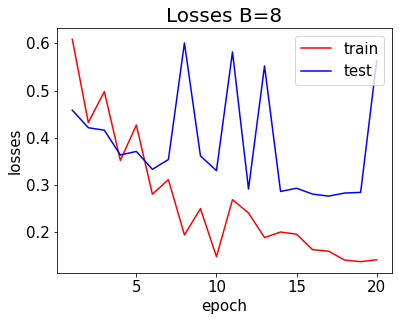

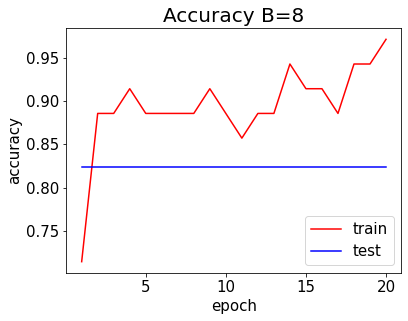

In [40]:
plottingLossAcc(losses,accuracy, Eb=Ebins)

In [25]:
y,y_score,correct,total,test_losses = test(testloader,batchsize)

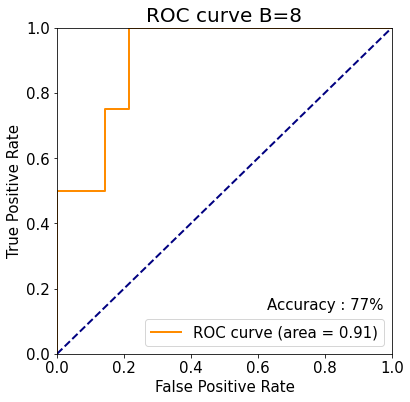

Accuracy of the network on the 20 test images: 77 %
threshold : 0.12807637453079224


In [26]:
roc(y,y_score,correct,total,Ebins)

In [27]:
sum(each.numel() for each in net.parameters() if each.requires_grad)
test_sets[0][0].shape
41 * 41 * 4

6724